In [2]:
import params as par
from background import *


import numba
from scipy.special import spherical_jn
from scipy import integrate
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
plt.rcParams.update(par.plot_params)
cp = copy.deepcopy
plt.rcParams.update(par.plot_params)

In [3]:
# Load data from GDM_FID.

τ_solve = pickle.load(open( "data/tau_solve.p", "rb" ) )
k_solve = pickle.load(open( "data/k_solve.p", "rb" ) )

wd_F = pickle.load(open( "data/w_d.p", "rb" ) )
Dwd_F = pickle.load(open( "data/Dw_d.p", "rb" ) )
cs2d_F = pickle.load(open( "data/cs2_d.p", "rb" ) )

δd = pickle.load(open( "data/delta_d.p", "rb" ) )
vd = pickle.load(open( "data/v_d.p", "rb" ) )
δɣ = pickle.load(open( "data/delta_g.p", "rb" ) )
vɣ = pickle.load(open( "data/v_g.p", "rb" ) )
Φ = pickle.load(open( "data/phi.p", "rb" ) )


(wd, Dwd, cs2d) =(wd_F, Dwd_F, cs2d_F)

N = len(τ_solve)

In [4]:
"""1 fluid"""

# set initial conditions
Φ0  = Φ[:,0] 
δɣ0 = δɣ[:,0] 
vɣ0 = vɣ[:,0] 
δd0 = δd[:,0] 
vd0 = vd[:,0] 

Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0])

@numba.jit(nopython=True)
def DY(τ, Y, wd, Dwd):
        dY = np.zeros((5,K_SOLVE))
        Φ = Y[0,:]
        δɣ = Y[1,:]
        vɣ = Y[2,:]
        δd = Y[3,:]
        vd = Y[4,:]
           
        #compute background quantities
        ℋi = 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
        ai =  a_eq*((α*τ/τr)**2 + 2*α*τ/τr)
        ybi = 1.68*ai*Ωb0/Ωr0

        Ωbi = Ωb0 * ai**-3.
        Ωɣi = Ωɣ0 * ai**-4.
        Ωdi = Ωc0 * ai**-3. + Ων0 * ai**-4.

        wdi = np.interp(τ, τ_solve, wd)
        Dwdi = np.interp(τ, τ_solve, Dwd)
        
        #interpolate cs2
        idx = np.searchsorted(τ_solve, τ) - 1
        d = (τ - τ_solve[idx]) / (τ_solve[idx + 1] - τ_solve[idx])
        cs2di = (1 - d) * cs2d[:,idx]   + cs2d[:,idx + 1] * d
        
        f = vd*Ωdi*(1+wdi) + 4./3.*Ωɣi*vɣ +  Ωbi*vɣ
        #DΦ
        dY[0,:]  = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve)*f
        #Dδɣ
        dY[1,:] = -4./3.*k_solve*vɣ + 4*dY[0,:]
        #Dvɣ
        dY[2,:] = (-ℋi*ybi*vɣ + k_solve*δɣ/3)/(
            4./3. + ybi) + k_solve*Φ
        #Dδd
        dY[3,:] = -(1+wdi)*(k_solve*vd-3*dY[0,:]) -\
            3*ℋi*(cs2di-wdi)*δd
        # Dvd
        dY[4,:] = -ℋi*(1-3*wdi)*vd - vd*Dwdi/(1+wdi) +\
            k_solve*δd*cs2di/(1+wdi) + k_solve*Φ

        return dY

In [5]:
# compute stepsizes for RK4
stepsizes = np.diff(τ_solve)

# implement RK4
@numba.jit(nopython=True)
def solve(wd, Dwd): 
    Y = np.zeros((len(τ_solve), 5, par.K_SOLVE))
    Y[0,:,:] = Y0
    for i, τi in enumerate(τ_solve[:-1]):
        ss = stepsizes[i]
        k1 = ss*DY(τi,Y[i,:,:], wd, Dwd)
        k2 = ss*DY(τi+ss/2,Y[i,:,:]+k1/2, wd, Dwd)
        k3 = ss*DY(τi+ss/2,Y[i,:,:]+k2/2, wd, Dwd)
        k4 = ss*DY(τi+ss,Y[i,:,:]+k3, wd, Dwd)
        
        Y[i+1,:,:] = Y[i,:,:] + k1/6 + k2/3 + k3/3 + k4/6
    return Y

In [6]:
# k and l list for integration
k_list2  = np.linspace(k_low,k_high,K_INT)
l_list = np.array([i for i in range(2,50,1)]+[i for i in range(50,200,5)] + 
     [i for i in range(200, 1200, 20)])
L = len(l_list)

"""Precompute Bessel Functions"""
# check if they're already stored
if 'JLK' not in globals():
    JLK = np.array([
        spherical_jn(l, k_list2*(τ_now-τ_rec))
                    for l in l_list])
    DJLK = np.array([
        spherical_jn(l, k_list2*(τ_now-τ_rec), derivative=True) 
        for l in l_list])


In [7]:
k_grid = np.broadcast_to(k_list2,(len(l_list),K_INT))
@numba.jit(nopython=True)
def get_Cl(wd, Dwd):
    # first compute mode evolution:
    Yf = solve(wd, Dwd)[-1,:,:]
    SW = Yf[0,:] + Yf[1,:]/4
    DOP = Yf[2,:]
    SWsd = SW*np.exp(-(k_solve*τs)**2)
    DOPsd = DOP*np.exp(-(k_solve*τs)**2)
    #ISW = 2*(2-8/y(xrec) + 16*xrec/y(xrec)**3)/(10*y(xrec))
    
    # get the power spectrum
    SWfill = np.interp(k_list2, k_solve, SW)
    DOPfill = np.interp(k_list2, k_solve, DOP)
    Dl = SWfill*JLK + DOPfill*(DJLK-JLK/(2*k_list2*(τ_now-τ_rec)))

    T = np.exp(-2*(k_list2*τs)**2 - (.03*k_list2*τ_rec)**2)
    Cl_itgd = Dl**2 *T /k_list2
    Cl = integrate.trapz(k_grid, Cl_itgd)
    Cl_out = l_list*(l_list + 1)*Cl
    return -Cl_out

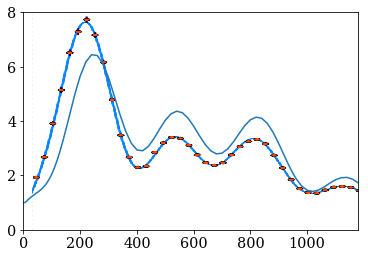

In [8]:
if True:
    """Compare to Planck 2015"""
    Cl0 = get_Cl(wd_F, Dwd_F)
    plt.plot(l_list, Cl0/Cl0[0], zorder=1)
    im = plt.imread('img/Cl_planck_30p.PNG')
    implot = plt.imshow(im, extent=[30,2500,0,8],zorder=0,aspect='auto')
    plt.xlim(0,l_list[-1])
    plt.show()

In [9]:
# compile the functions and time
time_functions=False
solve(wd_F, Dwd_F)
get_Cl(wd_F, Dwd_F)
if time_functions:
    print('timing mode evolution...')
    %timeit solve(wd_F, Dwd_F)
    print('\n')
    print('timing power spectrum computation...')
    %timeit get_Cl(wd_F, Dwd_F)


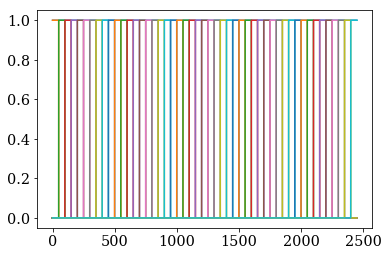

In [28]:
"""w-only PCA"""


# number of components:
N_C = 50
width = 50
# number of basis points
N_B = (N_C-1) * width 
J = np.zeros((L, N_C))
basis_type='sqr'

# derivative stepsize:
stepsize = 0.00001

# set the w basis
basis_domain = np.linspace(τ0, τ_rec, N_B)
B = np.zeros((N_B,N_C))

if basis_type =='sine':
    # sin/cosine basis
    for n in range(N_C//2):
        s_n = np.sin(n*np.pi*basis_domain/τ_rec)
        c_n = np.cos(n*np.pi*basis_domain/τ_rec)
        B[:,2*n] = s_n
        B[:,2*n+1] = c_n

if basis_type =='int_sqr':
    # integrated sq. pulse basis:
    B[:,0] = np.ones(N_B)
    for n in range(1, N_C):
        B[width*(n-1):width*n,n]=np.linspace(0,1,width+1)[1:] - 0.5
        B[width*n:,n]=0.5
        B[:width*(n-1),n]=-0.5

if basis_type =='sqr':
    # sq. pulse basis:
    B[:,0] = np.ones(N_B)
    for n in range(1, N_C):
        B[width*(n-1):width*n,n]=1

# standard basis vectors:

e = np.eye(N_C)

# Calculate the fiducial power spectrum
Cl0 = get_Cl(wd_F,Dwd)

#plt.plot(np.gradient(B[:,0],axis=0))
plt.plot(B[:,0:50])
plt.show()

In [29]:
# Compute the partials:
for n in range(N_C):
    global wd, Dwd
    # perturb w forward and backward
    Θw = e[n] * stepsize
    step = np.interp(τ_solve, basis_domain, B@Θw)
    wd_fwd = wd_F + step
    wd_bwd = wd_F - step
    
    # calculate Dw
    Dwd_fwd = np.gradient(wd_fwd, τ_solve)
    Dwd_bwd = np.gradient(wd_bwd, τ_solve)
    
    # evaluate Cl
    Cl_fwd = get_Cl(wd_fwd, Dwd_fwd)
    Cl_bwd = get_Cl(wd_bwd, Dwd_bwd)
    J[:,n] = (Cl_fwd - Cl_bwd)/(2.*stepsize) 


(128, 50)


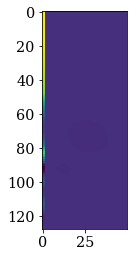

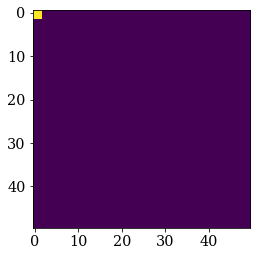

In [19]:
print(np.shape(J))
#compute Fisher matrix
F = np.transpose(J)@np.eye(L)@J
plt.imshow(J)
plt.show()
plt.imshow(F)
plt.show()

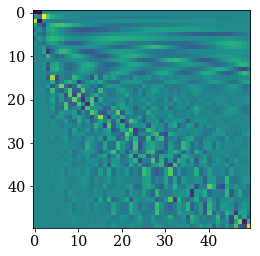

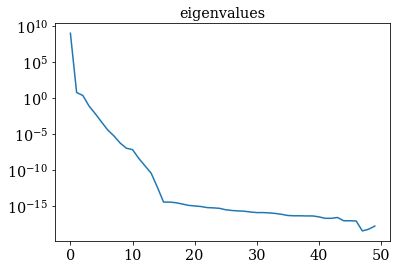

In [30]:
w, v = np.linalg.eig(F)
PC = np.real(v)
plt.imshow(PC.T)
plt.show()
plt.semilogy(np.abs(w))
plt.title('eigenvalues')
plt.show()

(50, 50)


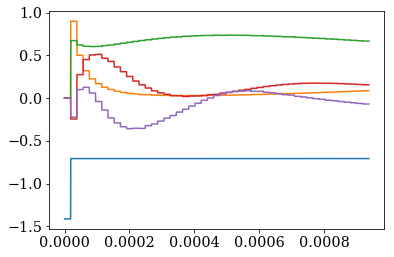

In [31]:
print(np.shape(PC))
PF = B@PC
plt.plot(basis_domain,PF[:,0:5])
#plt.ylim(-80,80)
plt.show()

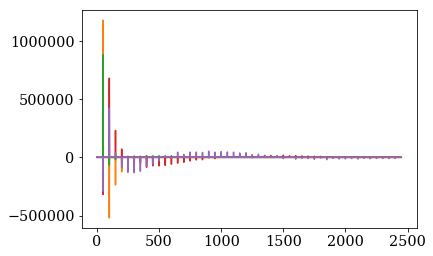

In [32]:
PF_Dw = np.gradient(PF[:,0:5], basis_domain, axis=0)
plt.plot(PF_Dw*np.sign(PF_Dw[0,0:5]+0.000001))
plt.show()